# Import Library

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=afad580965d56ef7697a449ab57717c74e7bbad9553770a8c8a9d644004a2122
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, StringIndexerModel
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import desc, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark = SparkSession.builder.appName("vehicle_regression").getOrCreate()

# Upload Data

In [ ]:
# Baca data Excel menggunakan pandas
excel_data = pd.read_excel("/content/data.xlsx")

# Konversi DataFrame pandas ke PySpark
spark_data = spark.createDataFrame(excel_data)

# Tampilkan skema DataFrame PySpark
spark_data.printSchema()

root
 |-- Kabupaten: string (nullable = true)
 |-- Tahun: long (nullable = true)
 |-- Jumlah: long (nullable = true)



# Visualisasi Data

In [ ]:
# Gunakan StringIndexer untuk mengonversi kolom string ke indeks numerik
indexer = StringIndexer(inputCol="Kabupaten", outputCol="kabupaten_index")
indexed_data = indexer.fit(spark_data).transform(spark_data)

In [ ]:
# Menampilkan beberapa baris data dari DataFrame
indexed_data.show()

+--------------------+-----+------+---------------+
|           Kabupaten|Tahun|Jumlah|kabupaten_index|
+--------------------+-----+------+---------------+
|   Kabupaten Cilacap| 2017|333292|            6.0|
|   Kabupaten Cilacap| 2018|685658|            6.0|
|   Kabupaten Cilacap| 2019|725053|            6.0|
|   Kabupaten Cilacap| 2020|752008|            6.0|
|   Kabupaten Cilacap| 2021|806833|            6.0|
|  Kabupaten Banyumas| 2017|604427|            1.0|
|  Kabupaten Banyumas| 2018|637506|            1.0|
|  Kabupaten Banyumas| 2019|673506|            1.0|
|  Kabupaten Banyumas| 2020|693638|            1.0|
|  Kabupaten Banyumas| 2021|739001|            1.0|
|Kabupaten Purbali...| 2017| 20932|           19.0|
|Kabupaten Purbali...| 2018|329288|           19.0|
|Kabupaten Purbali...| 2019|349584|           19.0|
|Kabupaten Purbali...| 2020|361588|           19.0|
|Kabupaten Purbali...| 2021|382763|           19.0|
|Kabupaten Banjarn...| 2017| 14698|            0.0|
|Kabupaten B

In [ ]:
# Group by tahun dan kabupaten, hitung jumlah kendaraan, dan urutkan secara descending
max_vehicle_count_per_year = indexed_data.groupBy("Tahun", "kabupaten_index").agg({"Jumlah": "sum"}).orderBy("Tahun", desc("sum(Jumlah)"))

# Ambil kabupaten dengan jumlah kendaraan terbanyak untuk setiap tahun
top_vehicle_per_year = max_vehicle_count_per_year.groupBy("Tahun").agg({"kabupaten_index": "first", "sum(Jumlah)": "max"})

# Gabungkan dengan indeks kabupaten untuk mendapatkan nama kabupaten
top_vehicle_per_year = top_vehicle_per_year.join(indexed_data.select("Kabupaten", "Kabupaten_index").distinct(),
                                                 top_vehicle_per_year["first(Kabupaten_index)"] == indexed_data["Kabupaten_index"]).drop("Kabupaten_index").withColumnRenamed("first(sum(Jumlah))", "Jumlah")

# Tampilkan hasil
top_vehicle_per_year.show()


+-----+----------------------+----------------+-------------+
|Tahun|first(kabupaten_index)|max(sum(Jumlah))|    Kabupaten|
+-----+----------------------+----------------+-------------+
| 2021|                  32.0|         1512234|Kota Semarang|
| 2018|                  32.0|         1295360|Kota Semarang|
| 2017|                  32.0|         1251200|Kota Semarang|
| 2020|                  32.0|         1382434|Kota Semarang|
| 2019|                  32.0|         1347260|Kota Semarang|
+-----+----------------------+----------------+-------------+



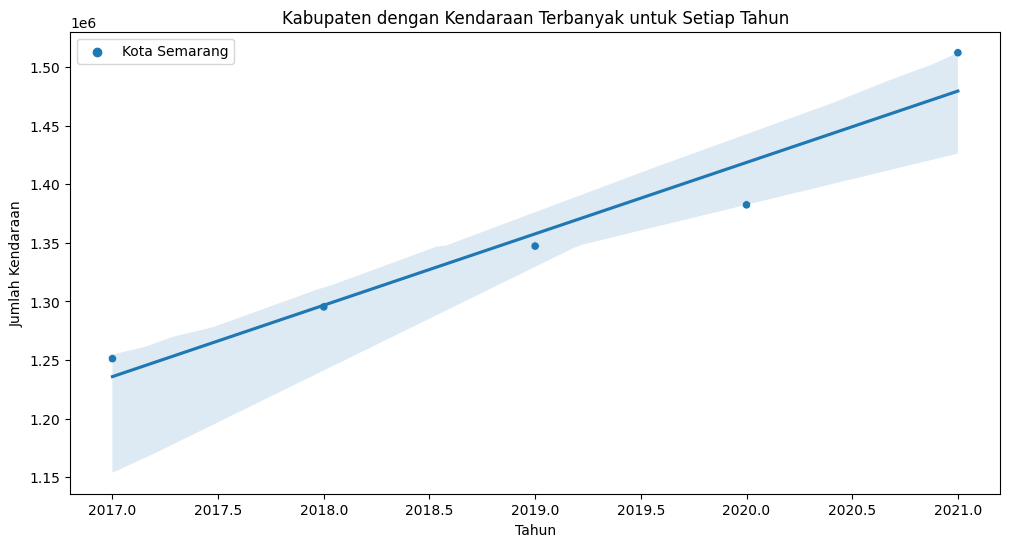

In [ ]:
# Ambil data hasil untuk plotting
result_pd = top_vehicle_per_year.toPandas()

# Plotting menggunakan scatter plot dan garis regresi
plt.figure(figsize=(12, 6))
sns.scatterplot(data=result_pd, x="Tahun", y="max(sum(Jumlah))", hue="Kabupaten", marker="o")

# Tambahkan garis regresi (line of best fit) menggunakan seaborn
sns.regplot(data=result_pd, x="Tahun", y="max(sum(Jumlah))", scatter=False)

plt.title("Kabupaten dengan Kendaraan Terbanyak untuk Setiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Kendaraan")
plt.legend()
plt.show()


# Pembagian Data

In [ ]:
# Persiapkan fitur dan target
feature_columns = ["kabupaten_index", "Tahun"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

indexed_data = assembler.transform(indexed_data)

In [ ]:
# Membagi data 80% untuk training dan 20% untuk testing
train_data, test_data = indexed_data.randomSplit([0.8, 0.2], seed=123)

# Pelatihan Model

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="Jumlah")

In [ ]:
model = lr.fit(train_data)

# Evaluasi

In [ ]:
# Evaluasi model pada data uji
evaluation = model.evaluate(test_data)

# Ambil metrics tambahan
r2 = evaluation.r2
mae = evaluation.meanAbsoluteError
mse = evaluation.meanSquaredError

print("Root Mean Squared Error (RMSE) on test data:", evaluation.rootMeanSquaredError)
print("R-squared (R2) on test data:", r2)
print("Mean Absolute Error (MAE) on test data:", mae)
print("Mean Squared Error (MSE) on test data:", mse)

Root Mean Squared Error (RMSE) on test data: 230221.94640741035
R-squared (R2) on test data: 0.16140353585774514
Mean Absolute Error (MAE) on test data: 144667.18604283122
Mean Squared Error (MSE) on test data: 53002144607.616516


# Prediksi Hingga 2025

In [ ]:
# Ambil daftar kabupaten dari data pelatihan
distinct_kabupaten = indexed_data.select("Kabupaten").distinct().collect()

# Ubah hasilnya menjadi list
list_of_kabupaten = [row["Kabupaten"] for row in distinct_kabupaten]

In [ ]:
# Buat DataFrame untuk setiap kombinasi tahun dan kabupaten
new_data = spark.createDataFrame([(tahun, kabupaten) for tahun in range(2022, 2026) for kabupaten in list_of_kabupaten], ["Tahun", "Kabupaten"])

# Gunakan StringIndexerModel untuk mengonversi kolom string ke indeks numerik
indexer_model = indexer.fit(spark_data)
new_data = indexer_model.transform(new_data)

# Persiapkan fitur dan target
feature_columns = ["kabupaten_index", "Tahun"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Gunakan VectorAssembler untuk menggabungkan fitur-fitur menjadi vektor
new_data = assembler.transform(new_data)

In [ ]:
# Gunakan model untuk prediksi
predictions_new_data = model.transform(new_data)

In [ ]:
# Ambil data hasil prediksi sebagai Pandas DataFrame
predictions_pd = predictions_new_data.select("Tahun", "Kabupaten", "prediction").toPandas()

# Bulatkan kolom "prediction" ke bilangan bulat terdekat
predictions_pd["Jumlah"] = predictions_pd["prediction"].round(0).astype(int)

# Pilih kolom yang ingin disimpan dalam DataFrame hasil prediksi
selected_columns = ["Tahun", "Kabupaten", "Jumlah"]

# Gabungkan data hasil prediksi dengan data awal menggunakan concat
merged_data_pd = pd.concat([excel_data, predictions_pd[selected_columns]], ignore_index=True)

merged_data_pd_sorted = merged_data_pd.sort_values(by="Kabupaten")

# Tampilkan DataFrame gabungan
print(merged_data_pd)

                Kabupaten  Tahun  Jumlah
0       Kabupaten Cilacap   2017  333292
1       Kabupaten Cilacap   2018  685658
2       Kabupaten Cilacap   2019  725053
3       Kabupaten Cilacap   2020  752008
4       Kabupaten Cilacap   2021  806833
..                    ...    ...     ...
310      Kabupaten Kendal   2025  745769
311       Kabupaten Demak   2025  760938
312      Kabupaten Jepara   2025  754871
313      Kabupaten Brebes   2025  767006
314  Kabupaten Pekalongan   2025  730599

[315 rows x 3 columns]


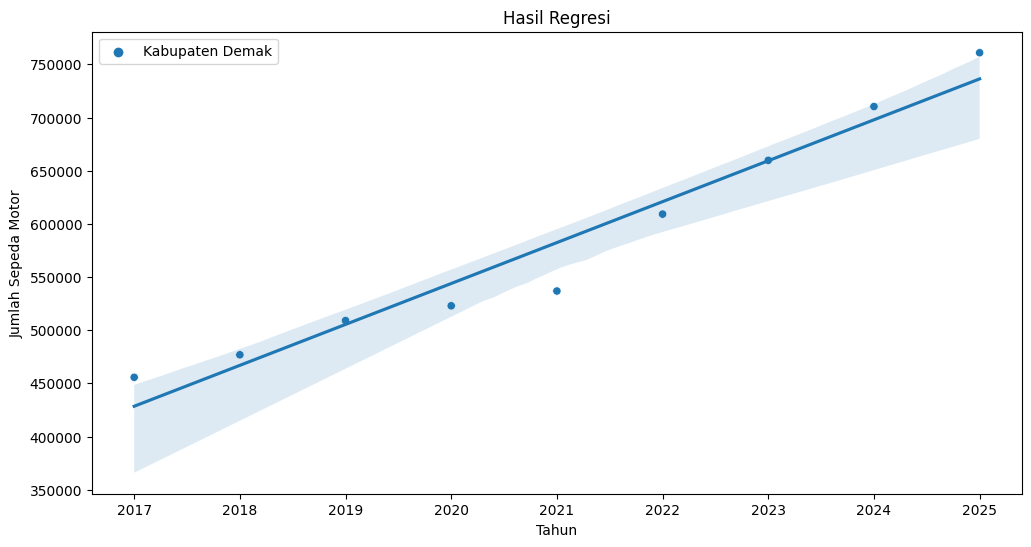

In [ ]:
# Filter data untuk Kabupaten Cilacap
vis_data = merged_data_pd[merged_data_pd["Kabupaten"] == "Kabupaten Demak"]

# Plotting menggunakan scatter plot dan garis regresi
plt.figure(figsize=(12, 6))
sns.scatterplot(data=vis_data, x="Tahun", y="Jumlah", hue="Kabupaten", marker="o")

# Tambahkan garis regresi (line of best fit) menggunakan seaborn
sns.regplot(data=vis_data, x="Tahun", y="Jumlah", scatter=False)

plt.title("Hasil Regresi")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Sepeda Motor")
plt.legend()
plt.show()

In [ ]:
# Simpan hasil ke dalam file Excel menggunakan pandas
merged_data_pd.to_excel("/content/predictions.xlsx", index=False)

In [ ]:
spark.stop()